In [1]:
# Native packages
from math import radians, degrees, sin, cos, asin, acos, sqrt
import datetime
import sys
import os
import requests

# Third-party packages for data manipulation
import numpy as np
import pandas as pd
import xarray as xr

# Third-party packages for data interpolation

from scipy import interpolate
from xgcm import Grid

# Third-party packages for data visualizations
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from mpl_toolkits.mplot3d import axes3d


from netrc import netrc
from urllib import request
from platform import system
from getpass import getpass
from http.cookiejar import CookieJar
from os.path import expanduser, join
from datetime import datetime, date, time, timedelta
import gsw as sw
import numpy as np
import xgcm.grid
import netCDF4 as nc4


#MB
import matplotlib.dates as mdates
import s3fs

# ***This library includes*** 
# - setup_earthdata_login_auth
# - download_llc4320_data
# - compute_derived_fields
# - get_survey_track
# - survey_interp
# - great_circle

In [2]:
import fastai
from django.urls import path
from fastai.imports import *

In [3]:
def setup_earthdata_login_auth(endpoint: str='urs.earthdata.nasa.gov'):
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        print('Please provide your Earthdata Login credentials for access.')
        print('Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass('Password: ')
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

In [4]:
def rotate_vector_to_EN(U, V, AngleCS, AngleSN):
                """
                rotate vector to east north direction.
                Assumes that AngleCS and AngleSN are already of same dimension as V and U (i.e. already interpolated to cell center)
                Parameters
                ----------
                U: xarray Dataarray
                    zonal vector component
                V: xarray Dataarray
                    meridional vector component
                AngleCS: xarray Dataarray
                    Cosine of angle of the grid center relative to the geographic direction
                AngleSN: xarray Dataarray
                    Sine of angle of the grid center relative to the geographic direction
                Returns
                ----------
                uE: xarray Dataarray
                    rotated zonal velocity
                vN: xarray Dataarray
                    rotated meridional velocity
                    
                    
                adapted from https://github.com/AaronDavidSchneider/cubedsphere/blob/main/cubedsphere/regrid.py
            
                """
                # rotate the vectors:
                uE = AngleCS * U - AngleSN * V
                vN = AngleSN * U + AngleCS * V

                return uE, vN

In [5]:
def download_llc4320_data(RegionName, datadir, start_date, ndays):
    """
    Check for existing llc4320 files in 'datadir' and download if they aren't found
    inputs XXX
    """
    ShortName = "MITgcm_LLC4320_Pre-SWOT_JPL_L4_" + RegionName + "_v1.0"
    date_list = [start_date + timedelta(days=x) for x in range(ndays)]
    target_files = [f'LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list of files to check for/download
    setup_earthdata_login_auth()
    
    # https access for each target_file
    url = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected"
    https_accesses = [f"{url}/{ShortName}/{target_file}" for target_file in target_files]
#     print(https_accesses)
    

    Path(datadir).mkdir(parents=True, exist_ok=True) # create datadir if it doesn't exist

    # list of dataset objects
    dds = []
    for https_access,target_file in zip(https_accesses,target_files):
        

        if not(os.path.isfile(datadir + target_file)):
            print('downloading ' + target_file) # print file name
            try:
                filename_dir = os.path.join(datadir, target_file)
                request.urlretrieve(https_access, filename_dir)
            except:
                print(' ---- error - skipping this file')

In [6]:
def checks(datadir):
    """
    Check for derived files in {datadir}/derived and compute if the files don't exist
    
    *Add checks for user entries
    """
    # directory to save derived data to - create if doesn't exist
    derivedir = datadir + 'derived/'
    if not(os.path.isdir(derivedir)):
        os.mkdir(derivedir)
        

In [7]:
def compute_derived_fields(RegionName, datadir, start_date, ndays):
    """
    Check for derived files in {datadir}/derived and compute if the files don't exist
    """
    # directory to save derived data to - create if doesn't exist
    derivedir = datadir + 'derived/'
    if not(os.path.isdir(derivedir)):
        os.mkdir(derivedir)
        
    # files to load:
    date_list = [start_date + timedelta(days=x) for x in range(ndays)]
    target_files = [f'{datadir}LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
    
    # list of derived files:
    derived_files = [f'{derivedir}LLC4320_pre-SWOT_{RegionName}_derived-fields_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files

        
    # loop through input files, then do the following:
    # - compute steric height
    # - interpolate vector quantities (velocity and wind) to the tracer grid
    # - rotate vectoor quantities to the geophysical (east/north) grid 
    # - compute vorticity (on the transformed grid)
    fis = range(len(target_files))
    
    cnt = 0 # count
    for fi in fis:
        # input filename:
        thisf=target_files[fi]
        # output filename:
        fnout = thisf.replace(RegionName + '_' , RegionName + '_derived-fields_')
        fnout = fnout.replace(RegionName + '/' , RegionName + '/derived/')
        # check if output file already exists
        if (not(os.path.isfile(fnout))):   
            print('computing derived fields for', thisf) 
            # load file:
            ds = xr.open_dataset(thisf)
            
            # -------
            # first time through the loop, load reference profile:
            # load a single file to get coordinates
            if cnt==0:
                # mean lat/lon of domain
                xav = ds.XC.isel(j=0).mean(dim='i')
                yav = ds.YC.isel(i=0).mean(dim='j')

                # for transforming U and V, and for the vorticity calculation, build the xgcm grid:
                # see https://xgcm.readthedocs.io/en/latest/xgcm-examples/02_mitgcm.html
                grid = xgcm.Grid(ds, coords={'X':{'center': 'i', 'left': 'i_g'}, 
                             'Y':{'center': 'j', 'left': 'j_g'},
                             'T':{'center': 'time'},
                             'Z':{'center': 'k'}})
                

                # --- load reference file of argo data
                # here we use the 3x3 annual mean Argo product on standard produced by IRPC & distributed by ERDDAP
                # https://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_defb_b79c_cb17.html
                # - download the profile closest to xav,yav once (quick), use it, then delete it.
                
                # URL gets temp & salt at all levels
                argofile = f'https://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_625d_3b64_cc4d.nc?temp[(0000-12-15T00:00:00Z):1:(0000-12-15T00:00:00Z)][(0.0):1:(2000.0)][({yav.data}):1:({yav.data})][({xav.data}):1:({xav.data})],salt[(0000-12-15T00:00:00Z):1:(0000-12-15T00:00:00Z)][(0.0):1:(2000.0)][({yav.data}):1:({yav.data})][({xav.data}):1:({xav.data})]'
                
                # delete the argo file if it exists 
                if os.path.isfile('argo_local.nc'):
                    os.remove('argo_local.nc')
                # use requests to get the file, and write locally:
                r = requests.get(argofile)
                file = open('argo_local.nc','wb')
                file.write(r.content)
                file.close()
                # open the argo file:
                argods = xr.open_dataset('argo_local.nc',decode_times=False)
                # get rid of time coord/dim/variable, which screws up the time in ds if it's loaded
                argods = argods.squeeze().reset_coords(names = {'time'}, drop=True) 
                # reference profiles: annual average Argo T/S using nearest neighbor
                Tref = argods["temp"]
                Sref = argods["salt"]
                # SA and CT from gsw:
                # see example from https://discourse.pangeo.io/t/wrapped-for-dask-teos-10-gibbs-seawater-gsw-oceanographic-toolbox/466
                Pref = xr.apply_ufunc(sw.p_from_z, -argods.LEV, yav)
                Pref.compute()
                SAref = xr.apply_ufunc(sw.SA_from_SP, Sref, Pref, xav, yav,
                                       dask='parallelized', output_dtypes=[Sref.dtype])
                SAref.compute()
                CTref = xr.apply_ufunc(sw.CT_from_pt, Sref, Tref, # Theta is potential temperature
                                       dask='parallelized', output_dtypes=[Sref.dtype])
                CTref.compute()
                Dref = xr.apply_ufunc(sw.density.rho, SAref, CTref, Pref,
                                    dask='parallelized', output_dtypes=[Sref.dtype])
                Dref.compute()
                
                
                cnt = cnt+1
                print()
                
            # -------
            
            # --- COMPUTE STERIC HEIGHT IN STEPS ---
            # 0. create datasets for variables of interest:
            ss = ds.Salt
            tt = ds.Theta
            pp = xr.DataArray(sw.p_from_z(ds.Z,ds.YC))
            
            # 1. compute absolute salinity and conservative temperature
            sa = xr.apply_ufunc(sw.SA_from_SP, ss, pp, xav, yav, dask='parallelized', output_dtypes=[ss.dtype])
            sa.compute()
            ct = xr.apply_ufunc(sw.CT_from_pt, sa, tt, dask='parallelized', output_dtypes=[ss.dtype])
            ct.compute()
            dd = xr.apply_ufunc(sw.density.rho, sa, ct, pp, dask='parallelized', output_dtypes=[ss.dtype])
            dd.compute()
            # 2. compute specific volume anomaly: gsw.density.specvol_anom_standard(SA, CT, p)
            sva = xr.apply_ufunc(sw.density.specvol_anom_standard, sa, ct, pp, dask='parallelized', output_dtypes=[ss.dtype])
            sva.compute()
            # 3. compute steric height = integral(0:z1) of Dref(z)*sva(z)*dz(z)
            # - first, interpolate Dref to the model pressure levels
            Drefi = Dref.interp(LEV=-ds.Z)
            dz = -ds.Z_bnds.diff(dim='nb').drop_vars('nb').squeeze() # distance between interfaces

            # steric height computation (summation/integral)
            # - increase the size of Drefi and dz to match the size of sva
            Db = Drefi.broadcast_like(sva)
            dzb = dz.broadcast_like(sva)
            dum = Db * sva * dzb
            sh = dum.cumsum(dim='k') 
            # this gives sh as a 3-d variable, (where the depth dimension 
            # represents the deepest level from which the specific volume anomaly was interpolated)
            # - but in reality we just want the SH that was determined by integrating over
            # the full survey depth, which gives a 2-d output:
            sh_true = dum.sum(dim='k') 
            
            # --- COMPUTE VORTICITY using xgcm and interpolate to X, Y
            # see https://xgcm.readthedocs.io/en/latest/xgcm-examples/02_mitgcm.html
            vorticity = (grid.diff(ds.V*ds.DXG, 'X') - grid.diff(ds.U*ds.DYG, 'Y'))/ds.RAZ
            vorticity = grid.interp(grid.interp(vorticity, 'X', boundary='extend'), 'Y', boundary='extend')
            
            

            # --- ROTATE AND TRANSFORM VECTOR QUANTITIES ---
            # interpolate U,V and oceTAUX, oceTAUY to the tracer grid
            # and rotate them to geophysical (east, north) coordinates instead of model ones:
            # 1) regrid 
            print('interpolating to tracer grid')
            U_c = grid.interp(ds.U, 'X', boundary='extend')
            V_c = grid.interp(ds.V, 'Y', boundary='extend')
            # do the same for TAUX and TAUY:
            oceTAUX_c = grid.interp(ds.oceTAUX, 'X', boundary='extend')
            oceTAUY_c = grid.interp(ds.oceTAUY, 'Y', boundary='extend')

            # 2) rotate U and V, and taux and tauy, using rotate_vector_to_EN:
            print('rotating to east/north')
            U_transformed, V_transformed = rotate_vector_to_EN(U_c, V_c, ds['AngleCS'], ds['AngleSN'])
            oceTAUX_transformed, oceTAUY_transformed = rotate_vector_to_EN(oceTAUX_c, oceTAUY_c, ds['AngleCS'], ds['AngleSN'])

            # --- save derived fields in a new file
            # - convert sh and zeta to datasets
            # NOTE can do this more efficiently in a single line w/out converting to dataset???
            dout = vorticity.to_dataset(name='vorticity')
            sh_ds = sh.to_dataset(name='steric_height')
            dout = dout.merge(sh_ds)
            sh_true_ds = sh_true.to_dataset(name='steric_height_true')
            dout = dout.merge(sh_true_ds)
            U_transformed_ds = U_transformed.to_dataset(name='U_transformed')
            V_transformed_ds = V_transformed.to_dataset(name='V_transformed')
            oceTAUX_transformed_ds = oceTAUX_transformed.to_dataset(name='oceTAUX_transformed')
            oceTAUY_transformed_ds = oceTAUY_transformed.to_dataset(name='oceTAUY_transformed')
            dout = dout.merge(U_transformed_ds).merge(V_transformed_ds)
            dout = dout.merge(oceTAUX_transformed_ds).merge(oceTAUY_transformed_ds)
            
            
            
            # add/rename the Argo reference profile variables to dout:
            tref = Tref.to_dataset(name='Tref')
            tref = tref.merge(Sref).rename({'salt': 'Sref'}).\
                rename({'LEV':'zref','latitude':'yav','longitude':'xav'})
            # - add ref profiles to dout and drop uneeded vars/coords
            dout = dout.merge(tref).drop_vars({'longitude','latitude','LEV'})
  
    
            # - add attributes for all variables
            dout.steric_height.attrs = {'long_name' : 'Steric height',
                                    'units' : 'm',
                                    'comments_1' : 'Computed by integrating the specific volume anomaly (SVA) multiplied by a reference density, where the reference density profile is calculated from temperature & salinity profiles from the APDRC 3x3deg gridded Argo climatology product (accessed through ERDDAP). The profile nearest to the center of the domain is selected, and T & S profiles are averaged over one year before computing ref density. SVA is computed from the model T & S profiles. the Gibbs Seawater Toolbox is used compute reference density and SVA. steric_height is given at all depth levels (dep): steric_height at a given depth represents steric height signal generated by the water column above that depth - so the deepest steric_height value represents total steric height (and is saved in steric_height_true'
                                       }
            dout.steric_height_true.attrs = dout.steric_height.attrs
            
            dout.vorticity.attrs = {'long_name' : 'Vertical component of the vorticity',
                                    'units' : 's-1',
                                    'comments_1' : 'computed on DXG,DYG then interpolated to X,Y'}
            
            dout.U_transformed.attrs['long_name'] = "Horizontal velocity in the eastward direction"
            dout.U_transformed.attrs['comments_1'] = "Horizontal velocity in the eastward direction at the center of the tracer cell on the native model grid."
            dout.U_transformed.attrs['comments_3'] = "Note: this has been transformed to the tracer grid and rotated to geophysical coordinates."

            dout.V_transformed.attrs['long_name'] = "Horizontal velocity in the northward direction"
            dout.V_transformed.attrs['comments_1'] = "Horizontal velocity in the northward direction at the center of the tracer cell on the native model grid."
            dout.V_transformed.attrs['comments_3'] = "Note: this has been transformed to the tracer grid and rotated to geophysical coordinates."

            dout.oceTAUX_transformed.attrs['long_name'] = "Ocean surface stress in the eastward direction"
            dout.oceTAUX_transformed.attrs['comments_1'] = "Ocean surface stress due to wind and sea-ice in the eastward direction centered over the the native model grid"
            dout.oceTAUX_transformed.attrs['comments_3'] = "Note: this has been transformed to the tracer grid and rotated to geophysical coordinates."

            dout.oceTAUY_transformed.attrs['long_name'] = "Ocean surface stress in the northward direction"
            dout.oceTAUY_transformed.attrs['comments_1'] = "Ocean surface stress due to wind and sea-ice in the northward direction centered over the the native model grid"
            dout.oceTAUY_transformed.attrs['comments_3'] = "Note: this has been transformed to the tracer grid and rotated to geophysical coordinates."
            
            
            
            dout.Tref.attrs = {'long_name' : f'Reference temperature profile at {yav.data}N,{xav.data}E',
                                    'units' : 'degree_C',
                                    'comments_1' : 'From Argo 3x3 climatology produced by APDRC'}
            dout.Sref.attrs = {'long_name' : f'Reference salinity profile at {yav.data}N,{xav.data}E',
                                    'units' : 'psu',
                                    'comments_1' : 'From Argo 3x3 climatology produced by APDRC'}
            
            dout.zref.attrs = {'long_name' : f'Reference depth for Tref and Sref',
                                    'units' : 'm',
                                    'comments_1' : 'From Argo 3x3 climatology produced by APDRC'}
            
            
            # - save netcdf file with derived fields
            netcdf_fill_value = nc4.default_fillvals['f4']
            dv_encoding = {}
            for dv in dout.data_vars:
                dv_encoding[dv]={'zlib':True,  # turns compression on\
                            'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
                            'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
                            'dtype':'float32',\
                            '_FillValue':netcdf_fill_value}
            # save to a new file
            print(' ... saving to ', fnout)
            # TROUBLESHOOTING::::: DELETE THE RETURN LINE
            #return dout, dv_encoding
            dout.to_netcdf(fnout,format='netcdf4',encoding=dv_encoding)

            
            
            # release & delete Argo file
            argods.close()
#             os.remove('argo_local.nc')

In [8]:
def get_survey_track(ds, sampling_details):
     
    """
    Returns the track (lat, lon, depth, time) and indices (i, j, k, time) of the 
    sampling trajectory based on the type of sampling (sampling_details[SAMPLING_STRATEGY]), 
    and sampling details (in dict sampling_details), which includes
    number of days, waypoints, and depth range, horizontal and vertical platform speed
    -- these can be typical values (default) or user-specified (optional)
    """
    
    
    survey_time_total = (ds.time.values.max() - ds.time.values.min()) # (timedelta) - limits the survey to a total time
    survey_end_time = ds.time.isel(time=0).data + survey_time_total # end time of survey
    # Convert lon, lat and z to index i, j and k with f_x, f_y and f_z
    # XC, YC and Z are the same at all times, so select a single time
    X = ds.XC.isel(time=0) 
    Y = ds.YC.isel(time=0)
    i = ds.i
    j = ds.j
    z = ds.Z.isel(time=0)
    k = ds.k
    f_x = interpolate.interp1d(X[0,:].values, i)
    f_y = interpolate.interp1d(Y[:,0].values, j)
    f_z = interpolate.interp1d(z, k, bounds_error=False)

    # Get boundaries and center of model region
    model_boundary_n = Y.max().values
    model_boundary_s = Y.min().values
    model_boundary_w = X.min().values
    model_boundary_e = X.max().values
    model_xav = ds.XC.isel(time=0, j=0).mean(dim='i').values
    model_yav = ds.YC.isel(time=0, i=0).mean(dim='j').values
    # --------- define sampling -------
    SAMPLING_STRATEGY = sampling_details['SAMPLING_STRATEGY']
    # ------ default sampling parameters: in the dict named "defaults" -----
    defaults = {}
    # default values depend on the sampling type
    # typical speeds and depth ranges based on platform 
    if SAMPLING_STRATEGY == 'sim_uctd':
        # typical values for uctd sampling:
        defaults['zrange'] = [-5, -500] # depth range of profiles (down is negative)
        defaults['hspeed'] = 5 # platform horizontal speed in m/s
        defaults['vspeed'] = 1 # platform vertical (profile) speed in m/s (NOTE: may want different up/down speeds)  
        defaults['PATTERN'] = 'lawnmower'
        defaults['AT_END'] = 'terminate'  # behaviour at and of trajectory: 'repeat', 'reverse', or 'terminate'
    elif SAMPLING_STRATEGY == 'sim_glider':
        defaults['zrange'] = [-1, -1000] # depth range of profiles (down is negative)
        defaults['hspeed'] = 0.25 # platform horizontal speed in m/s
        defaults['vspeed'] = 0.1 # platform vertical (profile) speed in m/s     
        defaults['AT_END'] = 'terminate'  # behaviour at and of trajectory: 'repeat', 'reverse', or 'terminate'
        defaults['PATTERN'] = 'lawnmower'
        #MB
    elif SAMPLING_STRATEGY == 'wave_glider':
        defaults['zrange'] = [-6, -100] # depth range of profiles (down is negative)
        defaults['hspeed'] = 1 # platform horizontal speed in m/s
        defaults['vspeed'] = 0 # platform vertical (profile) speed in m/s     
        defaults['AT_END'] = 'terminate'  # behaviour at and of trajectory: 'repeat', 'reverse', or 'terminate'
        defaults['PATTERN'] = 'back-forth'
        #MB
    elif SAMPLING_STRATEGY == 'sail_drone':
        defaults['zrange'] = [-1, -3] # depth range of profiles (down is negative)
        defaults['hspeed'] = 2.57 # platform horizontal speed in m/s
        defaults['vspeed'] = 0 # platform vertical (profile) speed in m/s     
        defaults['AT_END'] = 'terminate'  # behaviour at and of trajectory: 'repeat', 'reverse', or 'terminate'
        defaults['PATTERN'] = 'back-forth'
        #MB
    elif SAMPLING_STRATEGY == 'sim_mooring' or SAMPLING_STRATEGY == 'mooring':
        defaults['xmooring'] = model_xav # default lat/lon is the center of the domain
        defaults['ymooring'] = model_yav
        defaults['zmooring_TS'] = [-1, -10, -50, -100] # depth of T/S instruments
        defaults['zmooring_UV'] = [-1, -10, -50, -100] # depth of U/V instruments
    elif SAMPLING_STRATEGY == 'trajectory_file':
        # load file
        traj = xr.open_dataset(sampling_details['trajectory_file'])
        defaults['xwaypoints'] = traj.xwaypoints.values
        defaults['ywaypoints'] = traj.ywaypoints.values
        defaults['zrange'] = traj.zrange.values # depth range of profiles (down is negative)
        defaults['hspeed'] = traj.hspeed.values # platform horizontal speed in m/s
        defaults['vspeed'] = traj.vspeed.values # platform vertical (profile) speed in m/s
        defaults['PATTERN'] = traj.attrs['pattern']
    else:
        # if SAMPLING_STRATEGY not specified, return an error
        print('error: SAMPLING_STRATEGY ' + SAMPLING_STRATEGY + ' invalid')
        return -1
    
    #
    defaults['SAVE_PRELIMINARY'] = False
    
    
    # merge defaults & sampling_details
    # - by putting sampling_details second, items that appear in both dicts are taken from sampling_details: 
    sampling_details = {**defaults, **sampling_details}

    # ----- define x/y/z/t points to interpolate to
    # for moorings, location is fixed so a set of waypoints is not needed.
    # however, for "sim_mooring", tile/repeat the sampling x/y/t to form 2-d arrays,
    # so the glider/uCTD interpolation framework can be used.
    # - and for "mooring", skip the step of interpolating to "points" and interpolate directly to the new x/y/t/z 
    if SAMPLING_STRATEGY == 'sim_mooring':
        # time sampling is one per model timestep
#         ts = ds.time.values / 24 # convert from hours to days
        ts = ds.time.values # in hours
        n_samples = ts.size
        n_profiles = n_samples
        # same sampling for T/S/U/V for now. NOTE: change this later!        
        zs = np.tile(sampling_details['zmooring_TS'], int(n_samples)) # sample depths * # of samples 
        xs = sampling_details['xmooring'] * np.ones(np.size(zs))  # all samples @ same x location
        ys = sampling_details['ymooring'] * np.ones(np.size(zs))  # all samples @ same y location
        ts = np.repeat(ts, len(sampling_details['zmooring_TS']))  # tile to match size of other fields. use REPEAT, not TILE to get the interpolation right.

#         # depth sampling - different for TS and UV
#         zs_TS = np.tile(zmooring_TS, int(n_samples))
#         zs_UV = np.tile(zmooring_UV, int(n_samples))
#         xs_TS = xmooring * np.ones(np.size(zs_TS))
#         xs_UV = xmooring * np.ones(np.size(zs_UV))
#         ys_TS = ymooring * np.ones(np.size(zs_TS))
#         ys_UV = ymooring * np.ones(np.size(zs_UV))
#         ts_TS = np.tile(ts, int(n_samples))
        
        
#         lon_TS = xr.DataArray(xs_TS,dims='points'),
#         lat_TS = xr.DataArray(ys_TS,dims='points'),
#         dep_TS = xr.DataArray(zs_TS,dims='points'),
#         time_TS = xr.DataArray(ts,dims='points')
               
#         lon = lon_TS
#         lat = lat_TS
#         dep = dep_TS
#         time = time_TS
    elif SAMPLING_STRATEGY == 'mooring':
        ts = ds.time.values # in hours
        # same sampling for T/S/U/V for now. NOTE: change this later!  
        zs = sampling_details['zmooring_TS'] 
        xs = sampling_details['xmooring']
        ys = sampling_details['ymooring']
    else:
        # --- if not a mooring, define waypoints  
    
        # define x & y waypoints and z range
        # xwaypoints & ywaypoints must have the same size
        if sampling_details['PATTERN'] == 'lawnmower':
            # "mow the lawn" pattern - define all waypoints
            if not(SAMPLING_STRATEGY == 'trajectory_file'):
                # generalize the survey for this region
                xwaypoints = model_boundary_w + 1 + [0, 0, 0.5, 0.5, 1, 1, 1.5, 1.5, 2, 2]
                ywaypoints = model_boundary_s + [1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2]
        elif sampling_details['PATTERN'] == 'back-forth':
            if not(SAMPLING_STRATEGY == 'trajectory_file'):
                # repeated back & forth transects - define the end-points
                xwaypoints = model_xav + [-1, 1]
                ywaypoints = model_yav + [-1, 1]
            # repeat waypoints based on total # of transects: 
            dkm_per_transect = great_circle(xwaypoints[0], ywaypoints[0], xwaypoints[1], ywaypoints[1]) # distance of one transect in km
#           # time per transect, seconds, as a np.timedelta64 value
            t_per_transect = np.timedelta64(int(dkm_per_transect * 1000 / sampling_details['hspeed']), 's')    
            num_transects = np.round(survey_time_total / t_per_transect)
            for n in np.arange(num_transects):
                xwaypoints = np.append(xwaypoints, xwaypoints[-2])
                ywaypoints = np.append(ywaypoints, ywaypoints[-2])
        if SAMPLING_STRATEGY == 'trajectory_file':
            xwaypoints = sampling_details['xwaypoints']
            ywaypoints = sampling_details['ywaypoints']
        # if the survey pattern repeats, add the first waypoint to the end of the list of waypoints:
        if sampling_details['AT_END'] == 'repeat': 
            xwaypoints = np.append(xwaypoints, xwaypoints[0])
            ywaypoints = np.append(ywaypoints, ywaypoints[0])                
        
## Different function
        # vertical resolution
        # for now, use a constant  vertical resolution (NOTE: could make this a variable)
        #if ((SAMPLING_STRATEGY != 'wave_glider') and (SAMPLING_STRATEGY != 'sail_drone')): 
        zresolution = 1 # meters
        # max depth can't be deeper than the max model depth in this region
        sampling_details['zrange'][1] = -np.min([-sampling_details['zrange'][1], ds.Depth.isel(time=1).max(...).values])        
        zprofile = np.arange(sampling_details['zrange'][0],sampling_details['zrange'][1],-zresolution) # depths for one profile
        ztwoway = np.append(zprofile,zprofile[-1::-1])
        # time resolution of sampling (dt):
        dt = zresolution / sampling_details['vspeed'] # sampling resolution in seconds
        dt_td64 = np.timedelta64(int(dt), 's') # np.timedelta64 format
        # for each timestep dt 
        deltah = sampling_details['hspeed']*dt # horizontal distance traveled per sample
        deltav = sampling_details['vspeed']*dt # vertical distance traveled per sample

        # determine the sampling locations in 2-d space
        # - initialize sample locations xs, ys, zs, ts
        xs = []
        ys = []
        zs = []
        ts = []
        dkm_total = 0 
    

        for w in np.arange(len(xwaypoints)-1):
            # interpolate between this and the following waypoint:
            dkm = great_circle(xwaypoints[w], ywaypoints[w], xwaypoints[w+1], ywaypoints[w+1])
            # number of time steps (vertical measurements) between this and the next waypoint
            nstep = int(dkm*1000 / deltah) 
            yi = np.linspace(ywaypoints[w], ywaypoints[w+1], nstep)
            xi = np.linspace(xwaypoints[w], xwaypoints[w+1], nstep)
            xi = xi[0:-1] # remove last point, which is the next waypoint
            xs = np.append(xs, xi) # append
            yi = yi[0:-1] # remove last point, which is the next waypoint
            ys = np.append(ys, yi) # append
            dkm_total = dkm_total + dkm           
            # cumulative survey time to this point, in seconds, as a np.timedelta64 value
            t_total = np.timedelta64(int(dkm_total * 1000 / sampling_details['hspeed']), 's')
            
            # cut off the survey after survey_time_total
            if t_total > survey_time_total:
                break 
                
        # km for one lap of the survey
        dkm_once = dkm_total 

        # if time is less than survey_time_total, trigger AT_END behavior:
        if t_total < survey_time_total:
            if sampling_details['AT_END'] == 'repeat': 
                # start at the beginning again
                # - determine how many times the survey repeats:
                num_transects = np.round(survey_time_total / t_total)
                x_once = xs
                y_once = ys
                for n in np.arange(num_transects):
                    xs = np.append(xs, x_once)
                    ys = np.append(ys, y_once)
                    dkm_total += dkm_once
            elif sampling_details['AT_END'] == 'reverse': 
                # turn around & go in the opposite direction
                # - determine how many times the survey repeats:
                num_transects = np.round(survey_time_total / t_total)
                x_once = xs
                y_once = ys
                # append both a backward & another forward transect
                for n in np.arange(np.ceil(num_transects/2)):
                    xs = np.append(np.append(xs, x_once[-2:1:-1]), x_once)
                    ys = np.append(np.append(ys, y_once[-2:1:-1]), y_once)
                    dkm_total += dkm_once*2


        # repeat (tile) the two-way sampling depths 
        # - number of profiles we make during the survey:
        n_profiles = np.ceil(xs.size / ztwoway.size)
        zs = np.tile(ztwoway, int(n_profiles))
        zs = zs[0:xs.size] # limit to # of sample times
        ts = ds.time.isel(time=0).data + dt_td64 * np.arange(xs.size)
        # get rid of points with sample time > survey_time_total
        if survey_time_total > 0:
            idx = np.argmin(np.abs(ts - survey_end_time))# index of ts closest to survey_end_time
            print('originally, ', idx, ' points')
            # make sure this is multiple of the # of profiles:
            idx = int(np.floor((idx+1)/len(ztwoway)) * (len(ztwoway)))
            xs = xs[:idx]
            ys = ys[:idx]
            ts = ts[:idx]
            zs = zs[:idx]
            n_profiles = np.ceil(xs.size / ztwoway.size)
            # update t_total
            t_total = np.diff(ts[[0,-1]])
            t_total_seconds = int(t_total)/1e9 # convert from nanoseconds to seconds
            # use the speed to determine dkm_total (time * hspeed)
            dkm_total = t_total_seconds * sampling_details['hspeed'] / 1000
            print('limited to ', idx, 'points: n_profiles=', n_profiles, ', ', len(zprofile), 'depths per profile, ', len(ztwoway), 'depths per two-way')
            
        sampling_details['distance_total_km'] = dkm_total
        sampling_details['time_total_s'] = t_total_seconds  
        # -- end if not a mooring
        
    # ----- Assemble dataset: -----
    # (same regardless of sampling strategy - EXCEPT "mooring")
    if not SAMPLING_STRATEGY == 'mooring':
        # - real (lat/lon) coordinates:
        survey_track = xr.Dataset(
            dict(
                lon = xr.DataArray(xs,dims='points'),
                lat = xr.DataArray(ys,dims='points'),
                dep = xr.DataArray(zs,dims='points'),
                time = xr.DataArray(ts,dims='points'),
                n_profiles = n_profiles
            )
        )
        # - transform to i,j,k coordinates:
        survey_indices= xr.Dataset(
            dict(
                i = xr.DataArray(f_x(survey_track.lon), dims='points'),
                j = xr.DataArray(f_y(survey_track.lat), dims='points'),
                k = xr.DataArray(f_z(survey_track.dep), dims='points'),
                time = xr.DataArray(survey_track.time, dims='points'),
            )
        )
    elif SAMPLING_STRATEGY == 'mooring':
        survey_track = xr.Dataset(
            dict(
                lon = xr.DataArray(xs*[1], dims='position'),
                lat = xr.DataArray(ys*[1], dims='position'),
                dep = xr.DataArray(zs, dims='depth'),
                time = xr.DataArray(ts, dims='time')

            )
        )
        # - transform to i,j,k coordinates:
        survey_indices= xr.Dataset(
            dict(
                i = xr.DataArray(f_x(survey_track.lon), dims='position'),
                j = xr.DataArray(f_y(survey_track.lat), dims='position'),
                k = xr.DataArray(f_z(survey_track.dep), dims='depth'),
                time = xr.DataArray(survey_track.time, dims='time'),
            )
        )
    # store SAMPLING_STRATEGY and DERIVED_VARIABLES in survey_track so they can be used later
    survey_track['SAMPLING_STRATEGY'] = SAMPLING_STRATEGY
#     survey_track['DERIVED_VARIABLES'] = sampling_details['DERIVED_VARIABLES']
#    survey_track['SAVE_PRELIMINARY'] = sampling_details['SAVE_PRELIMINARY']
    return survey_track, survey_indices, sampling_details
 

In [9]:
def survey_interp(ds, survey_track, survey_indices, sampling_details):
    """
    interpolate dataset 'ds' along the survey track given by 
    'survey_indices' (i,j,k coordinates used for the interpolation), and
    'survey_track' (lat,lon,dep,time of the survey)
    
    Returns:
        subsampled_data: all field interpolated onto the track
        sh_true: 'true' steric height along the track
    
    """
      
        
    ## Create a new dataset to contain the interpolated data, and interpolate
    # for 'mooring', skip this step entirely - return an empty array for 'subsampled_data'
    SAMPLING_STRATEGY = survey_track['SAMPLING_STRATEGY']
    if SAMPLING_STRATEGY == 'mooring':
        subsampled_data = []
        
        # zgridded and times are simply zs, ta (i.e., don't interpolate to a finer grid than the mooring sampling gives)
        zgridded = survey_track['dep']
        times = survey_track['time']
        
        # -- initialize the dataset:
        sgridded = xr.Dataset(
            coords = dict(depth=(["depth"],zgridded),
                      time=(["time"],times))
        )
        # variable names (if DERIVED_VARIABLES is not set, don't load the vector quantities)
        if sampling_details['DERIVED_VARIABLES']:
            vbls3d = ['Theta','Salt','vorticity','steric_height', 'U', 'V']
            vbls2d = ['steric_height_true', 'Eta', 'KPPhbl', 'PhiBot', 'oceTAUX', 'oceTAUY', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux']
        else:
            vbls3d = ['Theta','Salt']
            vbls2d = ['Eta', 'KPPhbl', 'PhiBot', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux']
        
        
        # loop through 3d variables & interpolate:
        for vbl in vbls3d:
            print(vbl)
            sgridded[vbl]=ds[vbl].interp(survey_indices).compute().transpose()

        # loop through 2d variables & interpolate:
        # create 2-d survey track by removing the depth dimension
        survey_indices_2d =  survey_indices.drop_vars('k')
           
        
        
        for vbl in vbls2d:
            print(vbl)
            sgridded[vbl]=ds[vbl].interp(survey_indices_2d).compute()
            
        
        # clean up sgridded: get rid of the dims we don't need and rename coords
        
        if sampling_details['DERIVED_VARIABLES']:
            sgridded = sgridded.reset_coords(names = {'i', 'j', 'k'}).squeeze().rename_vars({'xav' : 'lon','yav' : 'lat'}).drop_vars(names={'i', 'j', 'k'})
        
            # for sampled steric height, we want the value integrated from the deepest sampling depth:
            sgridded['steric_height'] = (("time"), sgridded['steric_height'].isel(depth=int(len(zgridded))-1))
            # rename to "sampled" for clarity
            sgridded.rename_vars({'steric_height':'steric_height_sampled'})
        else:
            sgridded = sgridded.reset_coords(names = {'i', 'j', 'k'}).squeeze().drop_vars(names={'i', 'j', 'k'})
    
    else:
        subsampled_data = xr.Dataset(
            dict(
                t = xr.DataArray(survey_track.time, dims='points'), # call this time, for now, so that the interpolation works
                lon = xr.DataArray(survey_track.lon, dims='points'),
                lat = xr.DataArray(survey_track.lat, dims='points'),
                dep = xr.DataArray(survey_track.dep, dims='points'),
                points = xr.DataArray(survey_track.points, dims='points')
            )
        )

        # variable names (if DERIVED_VARIABLES is not set, don't load the vector quantities)
        if sampling_details['DERIVED_VARIABLES']:
            vbls3d = ['Theta','Salt','vorticity','steric_height', 'U', 'V']
            vbls2d = ['steric_height_true', 'Eta', 'KPPhbl', 'PhiBot', 'oceTAUX', 'oceTAUY', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux']
        else:
            vbls3d = ['Theta','Salt']
            vbls2d = ['Eta', 'KPPhbl', 'PhiBot', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux']
        
        
        print('Interpolating model fields to the sampling track...')
        # loop & interpolate through 3d variables:
        for vbl in vbls3d:
            subsampled_data[vbl]=ds[vbl].interp(survey_indices)

       

        # loop & interpolate through 2d variables:
        # create 2-d survey track by removing the depth dimension
        survey_indices_2d =  survey_indices.drop_vars('k')
        for vbl in vbls2d:
            subsampled_data[vbl]=ds[vbl].interp(survey_indices_2d)   

        # fix time, which is currently a coordinate (time) & a variable (t)
        subsampled_data = subsampled_data.reset_coords('time', drop=True).rename_vars({'t':'time'})

        # make xav and yav variables instead of coords, and rename
        if sampling_details['DERIVED_VARIABLES']:
            subsampled_data = subsampled_data.reset_coords(names = {'xav','yav'}).rename_vars({'xav' : 'lon_average','yav' : 'lat_average'})


            
        
        if sampling_details['SAVE_PRELIMINARY']:
            # ----- save preliminary data
            # (not applicable to mooring data)
            # add metadata to attributes
            attrs = sampling_details
            attrs['start_date'] = sampling_details['start_date'].strftime('%Y-%m-%d')
            end_date = subsampled_data['time'].data[-1]
            attrs['end_date'] = np.datetime_as_string(end_date,unit='D')
            attrs.pop('DERIVED_VARIABLES')    
            attrs.pop('SAVE_PRELIMINARY')
            
            # filename:
            filename_out = sampling_details['filename_out_base'] + '_subsampled.nc'
            print(f'saving to {filename_out}')
            subsampled_data.attrs = attrs
            netcdf_fill_value = nc4.default_fillvals['f4']
            dv_encoding={'zlib':True,  # turns compression on\
                        'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
                        'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
                        'dtype':'float32',\
                        '_FillValue':netcdf_fill_value}
            # save to a new file
            subsampled_data.to_netcdf(filename_out,format='netcdf4')
            
            
            
        # -----------------------------------------------------------------------------------
        # ------Regrid the data to depth/time (3-d fields) or subsample to time (2-d fields)
        print('Gridding the interpolated data...')
        
        # if SAVE PRELIMINARY, load the saved 'subsampled_data' file without dask
        # (otherwise, subsampled_data is already in memory)
        if sampling_details['SAVE_PRELIMINARY']:
            # now, reload with no chunking/dask and do the regridding
            subsampled_data = xr.open_dataset(filename_out)
        
        
        
        
        # get times associated with profiles:
        if SAMPLING_STRATEGY == 'sim_mooring':
            # - for mooring, use the subsampled time grid:
            times = np.unique(subsampled_data.time.values)
        else:
            # -- for glider/uctd, take the shallowest & deepest profiles (every second value, since top/bottom get sampled twice for each profile)
            time_deepest = subsampled_data.time.where(subsampled_data.dep == subsampled_data.dep.min(), drop=True).values[0:-1:2]
            time_shallowest = subsampled_data.time.where(subsampled_data.dep == subsampled_data.dep.max(), drop=True).values[0:-1:2]
            times = np.sort(np.concatenate((time_shallowest, time_deepest)))
            # this results in a time grid that may not be uniformly spaced, but is correct
            # - for a uniform grid, use the mean time spacing - may not be perfectly accurate, but is evenly spaced
            dt = np.mean(np.diff(time_shallowest))/2 # average spacing of profiles (half of one up/down, so divide by two)
            times_uniform = np.arange(survey_track.n_profiles.values*2) * dt

        # nt is the number of profiles (times):
        nt = len(times)  
        # xgr is the vertical grid; nz is the number of depths for each profile
        # depths are negative, so sort in reverse order using flip
        zgridded = np.flip(np.unique(subsampled_data.dep.data))
        nz = int(len(zgridded))

        # -- initialize the dataset:
        sgridded = xr.Dataset(
            coords = dict(depth=(["depth"],zgridded),
                      time=(["time"],times))
        )
        # -- 3-d fields: loop & reshape 3-d data from profiles to a 2-d (depth-time) grid:
        # first, extract each variable, then reshape to a grid
        
        for vbl in vbls3d:
            print(vbl)
            if sampling_details['SAVE_PRELIMINARY']:
                # not a dask array, so no "compute" command needed
                this_var = subsampled_data[vbl].data.copy() 
            else:
                this_var = subsampled_data[vbl].data.compute().copy() 
            # reshape to nz,nt
            this_var_reshape = np.reshape(this_var,(nz,nt), order='F') # fortran order is important!
            # for platforms with up & down profiles (uCTD and glider),
            # every second column is upside-down (upcast data)
            # starting with the first column, flip the data upside down so that upcasts go from top to bottom
            if SAMPLING_STRATEGY != 'sim_mooring':
                this_var_fix = this_var_reshape.copy()
                #this_var_fix[:,0::2] = this_var_fix[-1::-1,0::2] 
                this_var_fix[:,1::2] = this_var_fix[-1::-1,1::2]  # Starting with SECOND column
                sgridded[vbl] = (("depth","time"), this_var_fix)
            elif SAMPLING_STRATEGY == 'sim_mooring':
                sgridded[vbl] = (("depth","time"), this_var_reshape)
                
                
        if sampling_details['DERIVED_VARIABLES']:
            # for sampled steric height, we want the value integrated from the deepest sampling depth:
            sgridded['steric_height'] = (("time"), sgridded['steric_height'].isel(depth=nz-1).data)
            # rename to "steric_height_sampled" for clarity
            sgridded.rename_vars({'steric_height':'steric_height_sampled'})

  

        #  -- 2-d fields: loop & reshape 2-d data to the same time grid 
        for vbl in vbls2d:
            
            if sampling_details['SAVE_PRELIMINARY']:
                # not a dask array, so no "compute" command needed
                this_var = subsampled_data[vbl].data.copy() 
            else:
                this_var = subsampled_data[vbl].data.compute().copy() 
            # subsample to nt
            this_var_sub = this_var[0:-1:nz]
            sgridded[vbl] = (("time"), this_var_sub)

    # ------------ RETURN INTERPOLATED & GRIDDED DATA ------------

    # -- add variable attributes from ds
    if SAMPLING_STRATEGY == 'mooring':
        sgridded.attrs = ds.attrs
    else:
        # - find which variables in ds are also in our interpolated dataset:
        vars_ds = list(ds.keys())
        vars_sdata = list(subsampled_data.keys())
        vars_both = list(set(vars_ds) & set(vars_sdata))
        for var in vars_both:
            # copy over the attribute from ds:
            subsampled_data[var].attrs = ds[var].attrs
            sgridded[var].attrs = ds[var].attrs
    
    
    
    return subsampled_data, sgridded

In [10]:
# great circle distance (from Jake Steinberg) 
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)))

## Checks and Working:

In [11]:
# --------------------------------------------------------------------
# USER INPUTS:
# --------------------------------------------------------------------

# specify region from this list:
# WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST
# MarmaraSea  LabradorSea  CapeBasin
RegionName = 'ACC_SMST' 

# specify date range as start date & number of days.
start_date = date(2012,1,1)
# NOTE: ndays must be >1 
ndays = 60

# directory where data files are stored

# kd: lab
#datadir = '/Users/kdrushka/data/adac/mitgcm/netcdf/' + RegionName + '/'                      # input model data are here
#outputdir = '/Users/kdrushka/data/adac/osse_output/' + RegionName + '/'           # interpolated data stored here
#figdir = '/Users/kdrushka/Dropbox/projects/adac/figures/' + RegionName + '/' # store figures

#mb: laptop
#datadir = '/Volumes/TOSHIBA EXT 1/LLC4320_pre-SWOT_10_days/ACC_SMST/osse_model_input'  # input model data are here
#outputdir = '/Volumes/TOSHIBA EXT 1/LLC4320_pre-SWOT_10_days/ACC_SMST/osse_output'   # interpolated data stored here
#figdir = '/Volumes/TOSHIBA EXT 1/LLC4320_pre-SWOT_10_days/ACC_SMST/figures' # store figures

#ocean computer
#datadir = '/mnt/data/CapeBasin/osse_model_input/30days'  # input model data are here
#outputdir = '/mnt/data/CapeBasin/osse_output'   # interpolated data stored here
#figdir = '/mnt/data/CapeBasin/figures' # store figures#datadir = '/home/manjaree/Documents/LLC4320_pre-SWOT_10_days/ACC_SMST/osse_model_input/'  # input model data are here

#ocean computer
datadir = '/mnt/data/ACC_SMST/osse_model_input/30days'  # input model data are here
outputdir = '/mnt/data/ACC_SMST/osse_output'   # interpolated data stored here
figdir = '/mnt/data/ACC_SMST/figures' # store figures#datadir = '/home/manjaree/Documents/LLC4320_pre-SWOT_10_days/ACC_SMST/osse_model_input/'  # input model data are here

#datadir = '/mnt/data/ACC_SMST/osse_model_input/30days'  # input model data are here
#outputdir = '/mnt/data/ACC_SMST/osse_output'   # interpolated data stored here
#figdir = '/mnt/data/ACC_SMST/figures' # store figures#datadir = '/home/manjaree/Documents/LLC4320_pre-SWOT_10_days/ACC_SMST/osse_model_input/'  # input model data are here

#outputdir = '/home/manjaree/Documents/LLC4320_pre-SWOT_10_days/ACC_SMST/osse_output'   # interpolated data stored here
#figdir = '/home/manjaree/Documents/LLC4320_pre-SWOT_10_days/ACC_SMST/figures' # store figures

SAVE_FIGURES = False # True or False


# optional details for sampling (if not specified, reasonable defaults will be used)
# NOTE!! mooring and sim_mooring are different:
#    sim_mooring treats the mooring datapoints like a glider, 
#    whereas mooring interpolates directly to the mooring grid and should be faster
sampling_details_sim_glider = {
  'SAMPLING_STRATEGY' : 'sim_glider', 
#   'SAMPLING_STRATEGY' : 'trajectory_file', # options: sim_glider, sim_uctd, wave_glider or trajectory_file.add:  ASV
#   'SAMPLING_STRATEGY' : 'mooring', # options: sim_glider, sim_uctd, sim_mooring or trajectory_file.add: ASV. 
#    'SAMPLING_STRATEGY' : 'wave_glider', # options: wave_glider ..add trajectory file too?
    'PATTERN' : 'lawnmower', # back-forth or lawnmower 
   'zrange' : [-1, -1000],  # depth range of T/S profiles (down is negative). * add U/V range? *
#   'zmooring_TS' : list(range(-10,-1000,-10)) # instrument depths for moorings. T/S and U/V are the same.
 #   'zrange' : [-6, -100], # instrument depths for wave glider.  
  'hspeed' : 0.25,  # platform horizontal speed in m/s (for glider, uCTD)
 #   'hspeed' : 1,# platform horizontal (profile) speed in m/s  (for wave_glider)
   'vspeed' : 0.1, # platform vertical (profile) speed in m/s  (for glider, uCTD)
  # 'vspeed': 0 ,# platform vertical (profile) speed in m/s  (for wave_glider)
    'trajectory_file' : '../data/survey_trajectory_ACC_SMST_glider.nc', # if SAMPLING_STRATEGY = 'trajectory_file', specify trajectory file
    'AT_END' : 'reverse', # behaviour at and of trajectory: 'reverse', 'repeat' or 'terminate'. (could also 'restart'?)
    'DERIVED_VARIABLES' : False, # specify whether or not to process the derived variables (steric height, rotated velocity, vorticity) - slower and takes significant to derive/save the stored variables
  }


In [12]:
sampling_details_mooring = {
#  'SAMPLING_STRATEGY' : 'sim_glider', 
#   'SAMPLING_STRATEGY' : 'trajectory_file', # options: sim_glider, sim_uctd, wave_glider or trajectory_file.add:  ASV
   'SAMPLING_STRATEGY' : 'mooring', # options: sim_glider, sim_uctd, sim_mooring or trajectory_file.add: ASV. 
#    'SAMPLING_STRATEGY' : 'wave_glider', # options: wave_glider ..add trajectory file too?
    'PATTERN' : 'lawnmower', # back-forth or lawnmower 
#   'zrange' : [-1, -1000],  # depth range of T/S profiles (down is negative). * add U/V range? *
  'zmooring_TS' : list(range(-10,-1000,-10)), # instrument depths for moorings. T/S and U/V are the same.
 #   'zrange' : [-6, -100], # instrument depths for wave glider.  
 # 'hspeed' : 0.25,  # platform horizontal speed in m/s (for glider, uCTD)
 #   'hspeed' : 1,# platform horizontal (profile) speed in m/s  (for wave_glider)
#   'vspeed' : 0.1, # platform vertical (profile) speed in m/s  (for glider, uCTD)
  # 'vspeed': 0 ,# platform vertical (profile) speed in m/s  (for wave_glider)
    'trajectory_file' : '../data/survey_trajectory_ACC_SMST_glider.nc', # if SAMPLING_STRATEGY = 'trajectory_file', specify trajectory file
#    'AT_END' : 'reverse', # behaviour at and of trajectory: 'reverse', 'repeat' or 'terminate'. (could also 'restart'?)
    'DERIVED_VARIABLES' : False, # specify whether or not to process the derived variables (steric height, rotated velocity, vorticity) - slower and takes significant to derive/save the stored variables
  }

In [13]:
#sampling_details_mooring 

In [14]:
#TBR
datadir

'/mnt/data/ACC_SMST/osse_model_input/30days'

In [15]:
os.listdir(datadir)

['LLC4320_pre-SWOT_ACC_SMST_20120110.nc',
 'LLC4320_pre-SWOT_CapeBasin_20120101.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120122.nc',
 'LLC4320_pre-SWOT_CapeBasin_20120102.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120101.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120115.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120113.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120108.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120126.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120105.nc',
 'LLC4320_pre-SWOT_CapeBasin_20120105.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120125.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120118.nc',
 'LLC4320_pre-SWOT_CapeBasin_20120104.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120112.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120102.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120130.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120127.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120119.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120104.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120124.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120121.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20120103.nc',
 'LLC4320_pre-SWOT_ACC_SMST_20

In [16]:
#TBR
print(os.listdir(datadir))

['LLC4320_pre-SWOT_ACC_SMST_20120110.nc', 'LLC4320_pre-SWOT_CapeBasin_20120101.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120122.nc', 'LLC4320_pre-SWOT_CapeBasin_20120102.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120101.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120115.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120113.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120108.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120126.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120105.nc', 'LLC4320_pre-SWOT_CapeBasin_20120105.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120125.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120118.nc', 'LLC4320_pre-SWOT_CapeBasin_20120104.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120112.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120102.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120130.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120127.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120119.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120104.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120124.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120121.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120103.nc', 'LLC4320_pre-SWOT_ACC_SMST_20120129.nc', 'LLC4320_pr

In [17]:
#TBR
print(os.listdir(outputdir))

[]


In [18]:
#TBR
print(os.listdir(figdir))

[]


In [19]:
#TBR
#preview sampling details
sampling_details_sim_glider

{'SAMPLING_STRATEGY': 'sim_glider',
 'PATTERN': 'lawnmower',
 'zrange': [-1, -1000],
 'hspeed': 0.25,
 'vspeed': 0.1,
 'trajectory_file': '../data/survey_trajectory_ACC_SMST_glider.nc',
 'AT_END': 'reverse',
 'DERIVED_VARIABLES': False}

# Controls

In [20]:
#MB
sampling_details_wave_glider = {
 # 'SAMPLING_STRATEGY' : 'sim_glider', 
#   'SAMPLING_STRATEGY' : 'trajectory_file', # options: sim_glider, sim_uctd, wave_glider or trajectory_file.add:  ASV
#   'SAMPLING_STRATEGY' : 'mooring', # options: sim_glider, sim_uctd, sim_mooring or trajectory_file.add: ASV. 
    'SAMPLING_STRATEGY' : 'wave_glider', # options: wave_glider ..add trajectory file too?
    'PATTERN' : 'back-forth', # back-forth or lawnmower 
 #  'zrange' : [-1, -1000],  # depth range of T/S profiles (down is negative). * add U/V range? *
#   'zmooring_TS' : list(range(-10,-1000,-10)) # instrument depths for moorings. T/S and U/V are the same.
    'zrange' : [-6, -100], # instrument depths for wave glider.  
 # 'hspeed' : 0.25,  # platform horizontal speed in m/s (for glider, uCTD)
    'hspeed' : 1,# platform horizontal (profile) speed in m/s  (for wave_glider)
  # 'vspeed' : 0.1, # platform vertical (profile) speed in m/s  (for glider, uCTD)
   'vspeed': 0.0001 ,# platform vertical (profile) speed in m/s  (for wave_glider)
    'trajectory_file' : '../data/survey_trajectory_ACC_SMST_glider.nc', # if SAMPLING_STRATEGY = 'trajectory_file', specify trajectory file
    'AT_END' : 'terminate', # behaviour at and of trajectory: 'reverse', 'repeat' or 'terminate'. (could also 'restart'?)
    'DERIVED_VARIABLES' : False # specify whether or not to process the derived variables (steric height, rotated velocity, vorticity) - slower and takes significant to derive/save the stored variables
}
#MB

In [21]:
#sampling_details = sampling_details_mooring
sampling_details = sampling_details_sim_glider
#sampling_details = sampling_details_wave_glider
#sampling_details

# END

In [22]:
# uncomment the following two lines if troubleshooting osse_tools
# del sys.modules['osse_tools']  
# from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp

In [ ]:
# download files:
download_llc4320_data(RegionName, datadir, start_date, ndays)

Please provide your Earthdata Login credentials for access.
Your info will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter.


Username:  manjareeb
Password:  ············


downloading LLC4320_pre-SWOT_ACC_SMST_20120101.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120102.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120103.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120104.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120105.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120106.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120107.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120108.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120109.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120110.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120111.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120112.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120113.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120114.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120115.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120116.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120117.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120118.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120119.nc
downloading LLC4320_pre-SWOT_ACC_SMST_20120120.nc


In [57]:
datadir

'/mnt/data/ACC_SMST/osse_model_input/30days'

# Trying without compute derived fields

In [58]:
# derive & save new files with steric height & vorticity
#if sampling_details['DERIVED_VARIABLES']:
 #  compute_derived_fields1(RegionName, datadir, start_date, ndays)

#### Load all model data files. 
If `DERIVED_VARIABLES = True`, do *not* load U, V, or oceTAUX, oceTAUY as we will replace these with transformed versions .

Note that if `DERIVED_VARIABLES = False`, the vector variables U,V, TAUX and TAUY are in the reference frame of the model and must be rotated.

In [72]:
%%time
date_list = [start_date + timedelta(days=x) for x in range(ndays)]
#target_files = [f'{datadir}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
target_files = [f'{datadir}/LLC4320_pre-SWOT_ACC_SMST_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # lis
# chunk size ... aiming for ~100 MB chunks
# these chunks seem to work OK for up to ~20 day simulations, but more 
# testing is needed to figure out optimal parameters for longer simulations
tchunk = 6 
xchunk = 200
ychunk = 200

#tchunk = 6 
#xchunk = 150
#ychunk = 150

# drop the vector variables if loading derived variables because we are going to load the rotated ones in the next cell
if sampling_details['DERIVED_VARIABLES']:
    drop_variables={'U', 'V', 'oceTAUX', 'oceTAUY'}
else:
    drop_variables={}

ds = xr.open_mfdataset(target_files, parallel=True, 
                       drop_variables=drop_variables,
                      chunks={'i':xchunk, 'j':ychunk, 'time':tchunk})

# XC, YC and Z are the same at all times, so select a single time
# (note, this breaks for a single file - always load >1 file)
X = ds.XC.isel(time=0) 
Y = ds.YC.isel(time=0)

CPU times: user 1.68 s, sys: 367 ms, total: 2.05 s
Wall time: 1.6 s


In [73]:
%%time
# load the corresponding derived fields (includes steric height, vorticity, and transformed vector variables for current and wind stress)
if sampling_details['DERIVED_VARIABLES']:
    derivedir = datadir + 'derived/'
    derived_files = [f'{derivedir}LLC4320_pre-SWOT_{RegionName}_derived-fields_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
    dsd = xr.open_mfdataset(derived_files, parallel=True, chunks={'i':xchunk, 'j':ychunk, 'time':tchunk})
    
    # merge the derived and raw data
    ds = ds.merge(dsd)
    # rename the transformed vector variables to their original names
    ds = ds.rename_vars({'U_transformed':'U', 'V_transformed':'V', 
                         'oceTAUX_transformed':'oceTAUX', 'oceTAUY_transformed':'oceTAUY'})


# drop a bunch of other vars we don't actually use - can comment this out if these are wanted
ds = ds.drop_vars({'DXV','DYU', 'DXC','DXG', 'DYC','DYG', 'XC_bnds', 'YC_bnds', 'Zp1', 'Zu','Zl','Z_bnds', 'nb'})
ds

CPU times: user 2.65 ms, sys: 97 µs, total: 2.75 ms
Wall time: 2.76 ms


<xarray.Dataset>
Dimensions:   (j_g: 395, i: 480, i_g: 480, j: 395, k: 88, k_u: 88, k_l: 88,
               k_p1: 89, time: 720)
Coordinates:
  * j_g       (j_g) float32 0.0 1.0 2.0 3.0 4.0 ... 391.0 392.0 393.0 394.0
  * i         (i) float32 0.0 1.0 2.0 3.0 4.0 ... 475.0 476.0 477.0 478.0 479.0
  * i_g       (i_g) float32 0.0 1.0 2.0 3.0 4.0 ... 476.0 477.0 478.0 479.0
  * j         (j) float32 0.0 1.0 2.0 3.0 4.0 ... 390.0 391.0 392.0 393.0 394.0
  * k         (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 78 79 80 81 82 83 84 85 86 87
  * k_u       (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 78 79 80 81 82 83 84 85 86 87
  * k_l       (k_l) int32 0 1 2 3 4 5 6 7 8 9 ... 78 79 80 81 82 83 84 85 86 87
  * k_p1      (k_p1) int32 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88
  * time      (time) datetime64[ns] 2012-01-01 ... 2012-01-30T23:00:00
Data variables: (12/23)
    XC        (time, j, i) float32 dask.array<chunksize=(24, 200, 200), meta=np.ndarray>
    YC        (time, j, i) float32 dask.array<chunksize=(24, 200, 200), meta=np.ndarray>
    Depth     (time, j, i) float32 dask.array<chunksize=(24, 200, 200), meta=np.ndarray>
    AngleSN   (time, j, i) float32 dask.array<chunksize=(24, 200, 200), meta=np.ndarray>
    AngleCS   (time, j, i) float32 dask.array<chunksize=(24, 200, 200), meta=np.ndarray>
    XG        (time, j_g, i_g) float32 dask.array<chunksize=(24, 395, 480), meta=np.ndarray>
    ...        ...
    oceTAUY   (time, j_g, i) float64 dask.array<chunksize=(6, 395, 200), meta=np.ndarray>
    Theta     (time, k, j, i) float64 dask.array<chunksize=(6, 88, 200, 200), meta=np.ndarray>
    Salt      (time, k, j, i) float64 dask.array<chunksize=(6, 88, 200, 200), meta=np.ndarray>
    U         (time, k, j, i_g) float32 dask.array<chunksize=(6, 88, 200, 480), meta=np.ndarray>
    V         (time, k, j_g, i) float64 dask.array<chunksize=(6, 88, 395, 200), meta=np.ndarray>
    W         (time, k_l, j, i) float64 dask.array<chunksize=(6, 88, 200, 200), meta=np.ndarray>
Attributes: (12/56)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Dimitris Menemenlis et al.
    contributor:                     Chris Hill, Christopher E. Henze, Jinbo ...
    contributor_role:                MITgcm developer, AMES supercomputer sup...
    cdm_data_type:                   Grid
    Conventions:                     CF-1.7, ACDD-1.3
    ...                              ...
    time_coverage_end:               2012-01-01 23:00:00
    time_coverage_start:             2012-01-01 00:00:00
    title:                           LLC4320 regional Southern Ocean
    geospatial_lon_resolution:       variable
    geospatial_lat_resolution:       variable
    platform:                        MITgcm

### Create & plot sampling track
Based on the parameters in `sampling_details`

In [74]:
#del sys.modules['osse_tools_Copy1'] 
#from osse_tools_Copy1 import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp

survey_track, survey_indices, sampling_parameters = get_survey_track(ds, sampling_details)

# print specified sampling_details + any default values
sampling_parameters

originally,  258840  points
limited to  257742 points: n_profiles= 129.0 ,  999 depths per profile,  1998 depths per two-way


{'zrange': [-1, -1000.0],
 'hspeed': 0.25,
 'vspeed': 0.1,
 'AT_END': 'reverse',
 'PATTERN': 'lawnmower',
 'SAVE_PRELIMINARY': False,
 'SAMPLING_STRATEGY': 'sim_glider',
 'trajectory_file': '../data/survey_trajectory_ACC_SMST_glider.nc',
 'DERIVED_VARIABLES': False,
 'distance_total_km': 644.3525,
 'time_total_s': 2577410.0}

In [75]:
#sampling_parameters['hspeed']

In [76]:
%pwd

'/home/manjaree/.ssh/oceanliner/testing'

In [77]:
outputdir

'/mnt/data/ACC_SMST/osse_output'

In [78]:
# ---- generate name of file to save outputs in ---- 
filename_base = (f'OSSE_{RegionName}_{sampling_details["SAMPLING_STRATEGY"]}_{start_date}_to_{start_date + timedelta(ndays)}_maxdepth{int(sampling_parameters["zrange"][1])}')
filename_out_base = (f'{outputdir}{filename_base}')
print(filename_base)

OSSE_CapeBasin_sim_glider_2012-01-01_to_2012-01-31_maxdepth-1000


### Visualize the track over a single model snapshot:

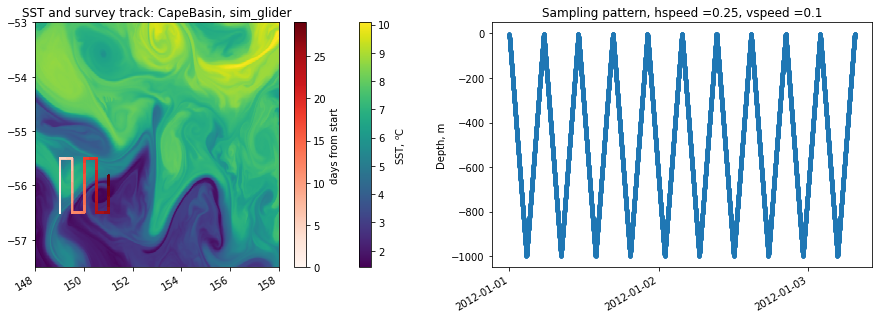

In [79]:
%matplotlib inline
plt.figure(figsize=(15,5))

# map of Theta at time zero
ax = plt.subplot(1,2,1)
ssto = plt.pcolormesh(X,Y,ds.Theta.isel(k=0, time=0).values, shading='auto')
if not (sampling_details['SAMPLING_STRATEGY'] == 'mooring' or sampling_details['SAMPLING_STRATEGY'] == 'sim_mooring'):
    tracko = plt.scatter(survey_track.lon, survey_track.lat, c=(survey_track.time-survey_track.time[0])/1e9/86400, cmap='Reds', s=0.75)
    plt.colorbar(ssto).set_label('SST, $^o$C')
    plt.colorbar(tracko).set_label('days from start')
    plt.title('SST and survey track: ' + RegionName + ', '+ sampling_details['SAMPLING_STRATEGY'])
else:
    plt.plot(survey_track.lon, survey_track.lat, marker='*', c='r')
    plt.title('SST and mooring location: ' + RegionName + ' region, ' + sampling_details['SAMPLING_STRATEGY'] )


# depth/time plot of first few datapoints
ax = plt.subplot(1,2,2)
iplot = slice(0,20000)
if not (sampling_details['SAMPLING_STRATEGY'] == 'mooring' or sampling_details['SAMPLING_STRATEGY'] == 'sim_mooring'):
    plt.plot(survey_track.time.isel(points=iplot), survey_track.dep.isel(points=iplot), marker='.')
else:
    # not quite right but good enough for now.
    # (times shouldn't increase with depth)
    plt.scatter((np.tile(survey_track['time'].isel(time=iplot), int(survey_track['dep'].data.size))),
         np.tile(survey_track['dep'], int(survey_track['time'].isel(time=iplot).data.size)),marker='.')             
#plt.xlim([start_date + datetime.timedelta(days=0), start_date + datetime.timedelta(days=2)])
plt.ylabel('Depth, m')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.title(f"Sampling pattern, hspeed ={sampling_parameters['hspeed']}, vspeed ={sampling_parameters['vspeed']}")


# save
#if SAVE_FIGURES:
#    plt.savefig('/data2/Dropbox/projects/adac/figures/' + filename_base + '_sampling.png', dpi=400, transparent=False, facecolor='white')

plt.show()

In [80]:
sampling_parameters

{'zrange': [-1, -1000.0],
 'hspeed': 0.25,
 'vspeed': 0.1,
 'AT_END': 'reverse',
 'PATTERN': 'lawnmower',
 'SAVE_PRELIMINARY': False,
 'SAMPLING_STRATEGY': 'sim_glider',
 'trajectory_file': '../data/survey_trajectory_ACC_SMST_glider.nc',
 'DERIVED_VARIABLES': False,
 'distance_total_km': 644.3525,
 'time_total_s': 2577410.0}

### Interpolate data with the specified sampling pattern (this is where the magic happens!)

In [81]:
#%%time

#del sys.modules['osse_tools'] 
#from osse_tools import survey_interp, get_survey_track

subsampled_data, sgridded = survey_interp(ds, survey_track, survey_indices, sampling_parameters)
sgridded

Interpolating model fields to the sampling track...
Gridding the interpolated data...
Theta
Salt


<xarray.Dataset>
Dimensions:   (depth: 999, time: 258)
Coordinates:
  * depth     (depth) float64 -1.0 -2.0 -3.0 -4.0 ... -997.0 -998.0 -999.0
  * time      (time) datetime64[ns] 2012-01-01 ... 2012-01-30T17:10:20
Data variables:
    Theta     (depth, time) float64 4.959 4.614 4.614 ... 2.015 2.048 2.048
    Salt      (depth, time) float64 34.02 33.94 33.94 ... 34.69 34.68 34.68
    Eta       (time) float64 -1.274 -0.7925 -0.6269 ... -0.8401 -0.448 -0.4646
    KPPhbl    (time) float64 33.39 16.83 25.93 24.69 ... 56.48 60.63 69.87 82.25
    PhiBot    (time) float64 414.5 418.7 422.1 420.8 ... 354.1 358.3 365.3 367.1
    oceFWflx  (time) float64 2.043e-05 1.923e-05 ... -0.0001377 -8.723e-05
    oceQnet   (time) float64 -348.4 -542.0 -338.5 -95.74 ... 28.93 71.65 44.26
    oceQsw    (time) float64 -519.5 -717.0 -490.9 ... -75.06 -13.38 -98.99
    oceSflux  (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

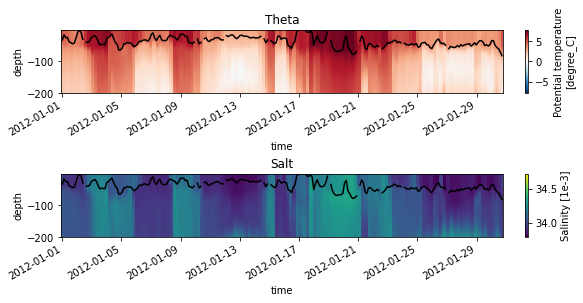

In [82]:
# 3d fields
vbls3d = ['Theta','Salt','U','V','vorticity']
vbls3d = ['Theta','Salt']
ylim = [min(sgridded['depth'].values), max(sgridded['depth'].values)]
ylim = [-200, -1]

nr = len(vbls3d) # # of rows
fig,ax=plt.subplots(nr,figsize=(8,len(vbls3d)*2),constrained_layout=True)


for j in range(nr):
    sgridded[vbls3d[j]].plot(ax=ax[j], ylim=ylim)
    ax[j].plot(sgridded.time.data, -sgridded.KPPhbl.data, c='k')
    ax[j].set_title(vbls3d[j])

if SAVE_FIGURES:
    plt.savefig(figdir + filename_base + '_3D.png', dpi=400, transparent=False, facecolor='white')

In [83]:
sampling_parameters

{'zrange': [-1, -1000.0],
 'hspeed': 0.25,
 'vspeed': 0.1,
 'AT_END': 'reverse',
 'PATTERN': 'lawnmower',
 'SAVE_PRELIMINARY': False,
 'SAMPLING_STRATEGY': 'sim_glider',
 'trajectory_file': '../data/survey_trajectory_ACC_SMST_glider.nc',
 'DERIVED_VARIABLES': False,
 'distance_total_km': 644.3525,
 'time_total_s': 2577410.0}

AttributeError: 'Dataset' object has no attribute 'oceTAUX'

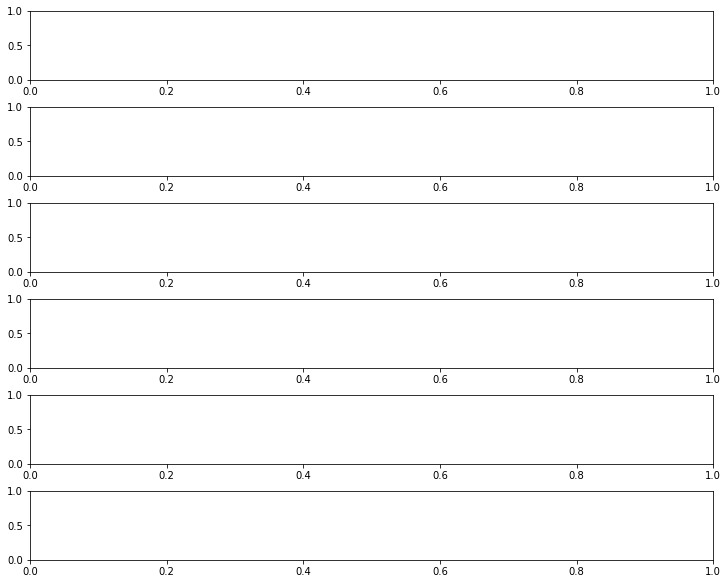

In [84]:
## selected 2d fields
j=0
nr = 6 # # of rows
fig,ax=plt.subplots(nr,figsize=(10,8),constrained_layout=True)


# wind vectors
ax[j].quiver(sgridded.time.data,0,sgridded.oceTAUX.data, sgridded.oceTAUY.data)
ax[j].set_title('Wind stress')    
ax[j].set_ylabel('N m-2')
# SH 
j+=1
ax[j].plot(sgridded.time,sgridded.steric_height-sgridded.steric_height.mean(), 
             sgridded.time.data,sgridded.steric_height_true-sgridded.steric_height_true.mean())
ax[j].set_title('Steric height')
ax[j].legend(['subsampled','true'])
ax[j].set_ylabel('m')

# SSH
j+=1
ax[j].plot(sgridded.time,sgridded.Eta)
ax[j].set_title('SSH')
ax[j].set_ylabel('m')

# MLD
j+=1
ax[j].plot(sgridded.time,sgridded.KPPhbl)
ax[j].set_title('MLD')
ax[j].set_ylabel('m')
ax[j].invert_yaxis()

# surface heat flux
j+=1
ax[j].plot(sgridded.time,sgridded.oceQnet, sgridded.time,sgridded.oceQsw)
ax[j].set_title('Surface heat flux into the ocean')
ax[j].legend(['total','shortwave'])
ax[j].set_ylabel('W m-2')

# surface FW flux
j+=1
ax[j].plot(sgridded.time,sgridded.oceFWflx)
ax[j].set_title('Surface freshwater flux into the ocean') 
ax[j].set_ylabel('kg m-2 s-1')

# horiz line:
for j in range(nr):
    ax[j].axhline(0, color='grey', linewidth=0.8)

if SAVE_FIGURES:
    plt.savefig(figdir + filename_base + '_2D.png', dpi=400, transparent=False, facecolor='white')
   